# ABOUT:
- this notebook compares the recommendation performance between Popularity recommender, SAR, and LightGCN on renttherunway dataset

In [1]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd
import os
import gzip
import json
import pandas as pd
import seaborn as sb
from scipy.sparse import save_npz, load_npz
from numpy import save, load 
import json

### read data

In [2]:
modcloth_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\RecSys Datasets\modcloth_final_data.json.gz"
COLS = ["user_id", "item_id", "quality"]

In [3]:
def read_review_data(path):
    def convert_json(json_string):
        try:
            return json.loads(json_string)
        except ValueError:
            return  
    with gzip.open(path, 'r') as fin:                # 4. gzip
        json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)
        json_str = json_bytes.decode('utf-8').split("\n")           # 2. string (i.e. JSON)
        data = []
        for elem in json_str:
            tmp_elem = convert_json(elem)
            if tmp_elem is None:
                continue
            data.append(tmp_elem)
    return data

In [4]:
modcloth_data = pd.DataFrame(read_review_data(modcloth_path))
modcloth_data = modcloth_data[COLS]
modcloth_data

,user_id,item_id,quality
0,991571,123373,5.0
1,587883,123373,3.0
2,395665,123373,2.0
3,875643,123373,5.0
4,944840,123373,5.0
...,...,...,...
82785,727820,807722,4.0
82786,197040,807722,5.0
82787,102493,807722,5.0
82788,756491,807722,4.0


In [5]:
modcloth_data = modcloth_data[modcloth_data.quality>=3]
modcloth_data['rating'] = 1

C:\Users\tanch\AppData\Local\Temp\ipykernel_21304\2361822535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modcloth_data['rating'] = 1


### data preparation
- preparation for cf training

In [6]:
COLS = ["user_id", "item_id", "rating"]
COL_USER, COL_ITEM = "user_id", "item_id"
COL_RATING = "rating"
# COL_TIMESTAMP = "review_date"
SPLIT_RATIO = 0.75
SEED = 0 
MIN_INTERACTIONS = 5
TOP_K = 10
BATCH_SIZE = 1024

In [7]:
def clean(df, cols, min_interactions, drop_cold_users = True, drop_cold_items = False):
    output_df = df.copy()
    
    # cleaning
    output_df = output_df.drop_duplicates(subset = [COL_USER, COL_ITEM])
    output_df[COL_RATING] = output_df[COL_RATING].apply(lambda rating: 1 if rating is None else rating)
    # output_df[COL_RATING] = output_df[COL_RATING].astype(int)
    
    # find warm items and users
    item_counts = output_df[COL_ITEM].value_counts()
    warm_items = item_counts[item_counts>=min_interactions]
    user_counts = output_df[COL_USER].value_counts()
    warm_users = user_counts[user_counts>=min_interactions]
    
    # keep only warm items and users
    if drop_cold_users:
        output_df = output_df[output_df[COL_USER].isin(warm_users.index)]
    if drop_cold_items:
        output_df = output_df[output_df[COL_ITEM].isin(warm_items.index)]
            
    return output_df

In [8]:
modcloth_data_reduced = clean(modcloth_data, cols = COLS, min_interactions = MIN_INTERACTIONS)

In [9]:
print("""
    Reduced Data:
    Total Ratings: {train_total}
    Unique Users: {train_users}
    Unique Items: {train_items}

    Original Data:
    Total Ratings: {test_total}
    Unique Users: {test_users}
    Unique Items: {test_items}
    """.format(
        train_total=len(modcloth_data_reduced),
        train_users=len(modcloth_data_reduced[COL_USER].unique()),
        train_items=len(modcloth_data_reduced[COL_ITEM].unique()),
        test_total=len(modcloth_data),
        test_users=len(modcloth_data[COL_USER].unique()),
        test_items=len(modcloth_data[COL_ITEM].unique()),
))


    Reduced Data:
    Total Ratings: 14154
    Unique Users: 2010
    Unique Items: 606

    Original Data:
    Total Ratings: 76248
    Unique Users: 45291
    Unique Items: 1336
    


In [10]:
train, test = python_stratified_split(modcloth_data_reduced, ratio=SPLIT_RATIO,
                                      min_rating=1, filter_by='user', 
                                      col_user=COL_USER, col_item=COL_ITEM, 
                                      seed=SEED)

In [11]:
print("""
    Train Data:
    Total Ratings: {train_total}
    Unique Users: {train_users}
    Unique Items: {train_items}

    Test Data:
    Total Ratings: {test_total}
    Unique Users: {test_users}
    Unique Items: {test_items}
    """.format(
        train_total=len(train),
        train_users=len(train[COL_USER].unique()),
        train_items=len(train[COL_ITEM].unique()),
        test_total=len(test),
        test_users=len(test[COL_USER].unique()),
        test_items=len(test[COL_ITEM].unique()),
))


    Train Data:
    Total Ratings: 10565
    Unique Users: 2010
    Unique Items: 543

    Test Data:
    Total Ratings: 3589
    Unique Users: 2010
    Unique Items: 387
    


## Model Training and Evaluation: SAR

In [12]:
# Similarity types: ["cooccurrence" | "cosine" | "inclusion index" | "jaccard" | "lift" | "mutual information" | "lexicographers mutual information"]
model_sar = SAR(
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    # col_timestamp=COL_TIMESTAMP,
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=False
)

In [13]:
# with Timer() as train_time:
model_sar.fit(train)

In [14]:
top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision     

0.04263681592039801

In [17]:
def convert_numpy_keys_to_raw(d):
    """
    Helper function to convert numpy keys in a dictionary to raw values
    """
    non_numpy_keys = list(map(int,d.keys()))
    non_numpy_values = list(map(int,d.values()))
    
    return dict(zip(non_numpy_keys,non_numpy_values))
def save_sar(model, directory, model_name):
    model_directory = os.path.join(directory, model_name)
    os.makedirs(model_directory, exist_ok=True)
    save_npz(file = os.path.join(model_directory, "sar_user_affinity.npz"), 
             matrix = model.user_affinity, 
             compressed=True)
    save(file = os.path.join(model_directory, "sar_item_similarity.npy"),
         arr = model.item_similarity)
    with open(os.path.join(model_directory, "sar_user2index.json"), "w") as f:
        json.dump(convert_numpy_keys_to_raw(model.user2index), f)
    with open(os.path.join(model_directory, "sar_index2item.json"), "w") as f:
        json.dump(convert_numpy_keys_to_raw(model.index2item), f)
        
def sar_load(model, directory):
    model.user_affinity = load_npz(file = os.path.join(directory,"sar_user_affinity.npz"))
    model.item_similarity = load(file = os.path.join(directory,"sar_item_similarity.npy"))
    with open(os.path.join(directory,"sar_index2item.json"), "r") as f:
        tmp_dict =  json.load(f)
        model.index2item = {int(k):v for k,v in tmp_dict.items()}
    with open(os.path.join(directory,"sar_user2index.json"), "r") as f:
        tmp_dict = json.load(f)
        model.user2index = {int(k):v for k,v in tmp_dict.items()}

In [18]:
save_sar(model_sar, r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models",
         "modcloth-sar")

## Train and Evaluate: Popularity Recommender

In [65]:
def construct_popular_predictions_table(test, model, top_k):
    user_ids = test.user_id.unique()
    popular_items = model.get_popularity_based_topk(top_k = top_k)
    output = pd.DataFrame()
    for user_id in user_ids:
        popular_items["user_id"] = user_id
        output = pd.concat([output, popular_items], axis = 0)
    return output

In [66]:
top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = TOP_K)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision  

0.02492537313432836

## Train and Evaluate: LightGCN

In [12]:
yaml_file = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\code1\config\lightgcn.yml"
save_model = True
save_epoch = 50
MODEL_DIR = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\models"

In [13]:
data = ImplicitCF(train = train, test=test, 
                  adj_dir=None, 
                  col_user=COL_USER, col_item=COL_ITEM, 
                  col_rating = COL_RATING,
                  seed=SEED)

C:\Users\tanch\anaconda3\envs\fyp1\lib\site-packages\recommenders\models\deeprec\DataModel\ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


In [14]:
loss_type = "AmpBPR2"
# loss_type = "OriginalBPR"
# loss_type = "AmpBPR2"
loss_neg_weight = 1.5
log_wandb = False

In [15]:
for i in range(3):
    hparams = prepare_hparams(yaml_file,
                                  n_layers=2,
                                  loss_type = loss_type, 
                                  loss_neg_weight = loss_neg_weight, 
                                  log_wandb = log_wandb,
                                  batch_size=BATCH_SIZE,
                                  epochs=50,
                                  learning_rate=0.005,
                                  eval_epoch=1,
                                  top_k=TOP_K,
                                  COL_USER = COL_USER,
                                  COL_ITEM = COL_ITEM,
                                  COL_RATING = COL_RATING,
                                  save_model = save_model,
                                save_epoch = save_epoch,
                                MODEL_DIR = MODEL_DIR
                                  )
    # initiate model
    model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [26]:
model.fit()

Epoch 1 (train)0.3s + (eval)0.1s: train loss = 0.69018 = (mf)0.69017 + (embed)0.00001, precision = 0.02493
Epoch 2 (train)0.1s + (eval)0.0s: train loss = 0.67149 = (mf)0.67146 + (embed)0.00003, precision = 0.02692
Epoch 3 (train)0.2s + (eval)0.0s: train loss = 0.60883 = (mf)0.60877 + (embed)0.00005, precision = 0.02607
Epoch 4 (train)0.1s + (eval)0.0s: train loss = 0.50646 = (mf)0.50635 + (embed)0.00010, precision = 0.02562
Epoch 5 (train)0.1s + (eval)0.1s: train loss = 0.42802 = (mf)0.42784 + (embed)0.00018, precision = 0.02498
Epoch 6 (train)0.1s + (eval)0.0s: train loss = 0.39042 = (mf)0.39018 + (embed)0.00024, precision = 0.02463
Epoch 7 (train)0.1s + (eval)0.0s: train loss = 0.38266 = (mf)0.38237 + (embed)0.00029, precision = 0.02507
Epoch 8 (train)0.1s + (eval)0.0s: train loss = 0.37287 = (mf)0.37255 + (embed)0.00032, precision = 0.02587
Epoch 9 (train)0.1s + (eval)0.0s: train loss = 0.35226 = (mf)0.35192 + (embed)0.00034, precision = 0.02672
Epoch 10 (train)0.1s + (eval)0.0s: tr

## Comparison
- Similarities with ML100k:
    - Both SAR and LightGCN improves on Populairty recommender
    
- Differences with ML100k:
    - SAR performed better than LightGCN

- What we can learn is that both **CF recommenders can improve upon Simple Popularity recommendation**. That means that, if popularity recommendation achieves a score of 0.2 precision@10, we can expect the CF recommenders to improve to let's say 0.25~. But if popularity recommendation achieves a score of only 0.02, then we can expect CF recommenders to improve performances to say only 0.03. **Depending on the type and size of datasets, we can expect vastly different performances**. It is inconclusive as to whether SAR or LightGCN performs better, **different algorithms perform differently depending on the dataset**

In [32]:
import seaborn as sb

In [33]:
precison_tmp = {
    "LightGCN":0.03816, 
    "SAR":0.042637,
    "Popularity":0.02493
}   

[Text(0.5, 0, 'Precision@10')]

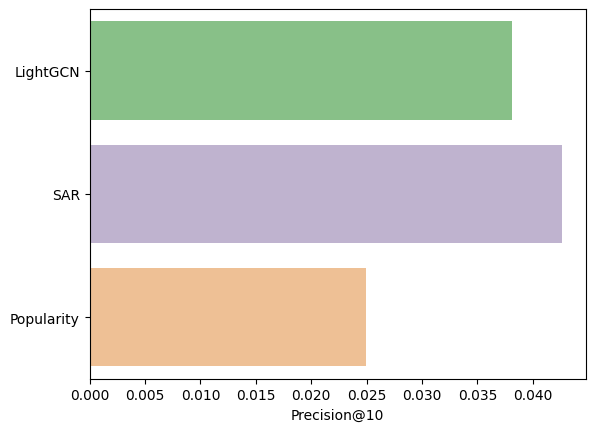

In [34]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")

## load and predict

In [17]:
save_path_str = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\models\epoch_50"
model.load(save_path_str)
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision     

INFO:tensorflow:Restoring parameters from C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\models\epoch_50


0.03786069651741293

In [18]:
model.recommend_k_items(pd.DataFrame({"user_id":["999697"]}), top_k=TOP_K, remove_seen=True)

,user_id,item_id,prediction
0,999697,645822,3.555731
1,999697,412737,3.384269
2,999697,391519,2.968252
3,999697,401773,2.734417
4,999697,200824,2.700134
5,999697,486643,2.668071
6,999697,539980,2.380388
7,999697,406357,2.226636
8,999697,175771,2.195363
9,999697,654585,2.061988


In [17]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\data\train.pkl"
train.to_pickle(path)
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\data\test.pkl"
test.to_pickle(path)

<!-- ## Train and Evaluate: Popularity Recommender -->

In [112]:
# class PopRecommender():
#     def __init__(self, COL_ITEM = "itemID", COL_USER = "userID"):
#         self.COL_ITEM = COL_ITEM
#         self.COL_USER = COL_USER
#     def fit(self, train):
#         self.train = train
#         self.memory = train[COL_ITEM].value_counts().keys().tolist()
#     def recommend(self, user_id, num_rec = 20, filtered_item_ids = [], remove_seen = True):
#         if remove_seen:
#             remove_item_ids = self._get_user_liked_item_ids(user_id)
#             remove_item_ids += filtered_item_ids
        
#         # recommend num_rec items
#         rec_items = []
#         count = 0
#         for item_id in self.memory:
#             if item_id not in filtered_item_ids: 
#                 count+=1
#                 rec_items.append(item_id)
#             if count >= num_rec:
#                 break
#         return rec_items
    
#     def recommend_k_items(self, test, top_k=10, remove_seen=True):
#         output = pd.DataFrame()
#         for userID in test[self.COL_USER]:
#             rec_items = self.recommend(userID, num_rec = top_k, remove_seen = remove_seen)
#             tmp = pd.DataFrame(rec_items, columns = [self.COL_ITEM])
#             tmp[self.COL_USER] = userID
#             output = pd.concat([output, tmp], axis = 0)
#         output["prediction"] = 1
#         return output
#     def _get_user_liked_item_ids(self, user_id):
#         return self.train[self.train[self.COL_USER] == user_id][self.COL_ITEM].tolist()

In [113]:
# rec = PopRecommender(COL_ITEM = COL_ITEM, COL_USER = COL_USER)
# rec.fit(train)
# top_k = rec.recommend_k_items(test, top_k = TOP_K, remove_seen = True)
# eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating='rating', k=TOP_K)
# eval_precision